# Final Project: Mine the Concordy

# ANSH SINGHAL

# The Sports Columns from 120 years of The Concordy

For my final project, I will be focusing my 'research' on the sports part of the concordy as I feel it is a great topic to explore when it comes to a resource like the concordy. It is reporting along the same lines, with certain deviation, and has gradual shifting patterns in terms of tones, choice of reporting etc, which can be analysed. It will also be relatively easier to extract just sports content as opposed to any other isolated topic given that all matters sports are condensed into one chunky sports page, all I have to do is identify those sports pages, and then begin inspecting them!

In [ ]:
import nltk
import string
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = stopwords.words('english')
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import urllib
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem import PorterStemmer
ps = PorterStemmer() 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Cleaning
We're now going to be first attempting to scrape through the data without doing any actual analysis to retrieve all the sports pages (so I won't be looking at sports related articles that weren't on sports pages), and will be employing a page-wise approach for the following reason(s):
```

* "Pre-Season Practice shows good signs for the Dutchmen", it is tough to code something that would be able to pick this up as a sports related article, and it is even more complex to then decide what columns belong to said article the way OCR has scanned these papers.
* Naturally a majority of the sports related text is condensed on one page anyways (usually the last few)
* From the Union Athletics website, I got myself a list of sports at Union to help me with this process (Baseball, Basketball, Crew, Cross Country, Football, Ice Hockey, Lacrosse, Soccer, Swimming & Diving, Tennis, Track & Field, Golf, Softball, Volleyball, Field Hockey)

```
I decided to thus go out and make a dictionary of all sports content (key being the year and value being a dump of sports text from that year). This way for all my analysis moving forward I am only having to iterate through a simple dictionary which contains all the relevant data

In the meanwhile, while I am iterating through the data, I thought it'd be wise to also maintain a list of months that didn't have any issue of the concordy to save time moving forward.

I am aware that my "sports content" will also contain a lot of non-sports junk such as advertisements, spill-over articles from other sections, etc, but since I cannot clear these out (articles aren't demarcated), and majority of the text on said page is sports related, it should suffice

* In my quest to figure out how to "grab" the relevant data, I had to go through the pdfs of issues, and began applying a manual approach (binary search), to figure out the aforementioned relevant years as well as the page on which the sports content appears (second last or last in most cases) 
* As for the pages themselves, I figured the pages were separated by a double enter ('\n\n')
* If I am not able to figure out a way to extract the last page from each issue, I could build up a function that is able to identify whether or not a certain page is sports related or not by training a classifier using scikit.


As of now I found out, manually, that up until volume 93 all papers had the second last page vaguely dedicated to sports whereas from volume 94 (september 1964) a dedicated 'concordy sports' page was the last page every passing issue.


However the larger problem I was facing was the fact that one document had multiple issues from that month, and so I couldn't employ say a 'Extract 2nd last page from these docs, and last page from these docs' approach, moreover there  were inconsistencies in the way the pages were formatted, unlike scripts on the web for example.

It became clear to me very soon, that it would be both cool, and very helpful for me to build a tool that could identify all the sports pages in a document and then add them to an archive of 'sports content' over which I had free reign to conduct my '*research*'.

So I trained a tfidf vector to the October Issues from 1970, got documents that were similar to a known sports page from the document, and created a list of sports pages from this volume (based on outlier higher cosine similarity scores when multiplied with its own transpose), which I then verified to be true manually.

In [ ]:
# TRAINING TO IDENTIFY SPORTS PAGES
folder = "https://cs-gitlab.union.edu/webbn/concordy/raw/master/Text/"
path = folder+'1970-10.txt'
req = Request(path)
try:
  urlopen(req)
except HTTPError as e:
  print(monthStr,'MISSING: Error code: ', e.code)

else:
  response = urllib.request.urlopen(path)
  data = response.read()      
  text = data.decode('utf-8') 
  
  pages = text.split('\n\n')
pages.pop(27)
pages.pop(41)
print ('No of pages:',len(pages))

for page_no in range(0,len(pages)):
  cleaned_words = [word.lower() for word in nltk.word_tokenize(pages[page_no]) if word.lower() not in stop and word.lower() not in string.punctuation+'''•~`''']
  stems = [ps.stem(word) for word in cleaned_words]
  pages[page_no] = ' '.join(stems)
tfidfVec = TfidfVectorizer()
tfidf_matrix = tfidfVec.fit_transform(pages)

print ('Size of Vocabulary being used to train sports page cosine:',len(tfidfVec.vocabulary_))


No of pages: 47
Size of Vocabulary being used to train sports page cosine: 10000


In [ ]:
print (tfidfVec.vocabulary_)

In [ ]:
cos_similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
print('Cosine Similarity Matrix to a known sports page from volume (last page of last issue that month)\n\n',cos_similarity_matrix[-2])

Cosine Similarity Matrix to a known sports page from volume (last page of last issue that month)

 [0.07716647 0.1026053  0.06936236 0.08474151 0.07832995 0.03597032
 0.09040066 0.46008854 0.11302025 0.08569674 0.08136468 0.42932316
 0.06838823 0.06291394 0.07679031 0.45639673 0.11096087 0.08566563
 0.10652352 0.48186687 0.10269526 0.07941238 0.10300047 0.07662515
 0.06198041 0.0763911  0.06647464 0.5345978  0.08853238 0.08989203
 0.07493165 0.09702288 0.46346069 0.07779924 0.07311994 0.10747783
 0.54224239 0.07818251 0.10226005 0.07112961 0.51050344 0.06042034
 0.05177828 0.05949285 0.09052971 1.         0.        ]


The reason that this I'm displaying the [-2] index and not [-1] is that there is a double enter at the end so a faulty last page '' is being created

From the list above, it is clear that there are certain outliers when it comes to pages similar to this particular sports page, and it seems like anything with a score above 0.15 should fit the criteria (I arrived at this number by testing the code a few times before hitting a number I felt would capture most of the sports pages without gathering pages that weren't sports based but had some sports related terms, etc.) I felt it was less detrimental that we missed out on some sports pages than getting all sports pages but also extra pages in the process, since the sports pages nearing the blurry line weren't all sport to begin with, and won't be worth a whole non-sports page that would tamper with the results.

It is also important to understand that it was quite some time before which a whole dedicated sports page was brought about instead of a page with some sports articles alongside others, as well as the observation that in general there were more ads on the '*sports page*'. Thus the reliability of the information increases as we move through the years, keep that in mind with the results we receive at the end.

In [ ]:
sports_docs = []
for page_no in range (0,len(cos_similarity_matrix[-2])):
  if cos_similarity_matrix[-2][page_no]>0.15:
    sports_docs+=[page_no]

print ('Pages from document pertaining to Oct 1970 issues that are sports related:', sports_docs)


Pages from document pertaining to Oct 1970 issues that are sports related: [7, 11, 15, 19, 27, 32, 36, 40, 45]


In [ ]:
# Similarity Scores of the sports page from the last year of that issue compared to the rest of the sports pages (higher is more similar)
'''
sports_content = {1964:[]}
year = 1964
test_doc = [pages[-2]]
test_vector = tfidfVec.transform(test_doc)
test_cosine = (tfidf_matrix*test_vector.T).toarray()
test_sport_scores = []
for page_no in sports_docs:
  test_sport_scores+=[test_cosine[page_no]]
  print (test_cosine[page_no])
'''

'\nsports_content = {1964:[]}\nyear = 1964\ntest_doc = [pages[-2]]\ntest_vector = tfidfVec.transform(test_doc)\ntest_cosine = (tfidf_matrix*test_vector.T).toarray()\ntest_sport_scores = []\nfor page_no in sports_docs:\n  test_sport_scores+=[test_cosine[page_no]]\n  print (test_cosine[page_no])\n'

## Similarity Scores of the sports page from the last year of that issue compared to the rest of the sports pages (higher is more similar)
Run code cell above to check

Pre-Stemming:
1. [0.37529046]
2. [0.37913846]
3. [0.3794788]
4. [0.40480631]
5. [0.4465135]
6. [0.38348684]
7. [0.46486959]
8. [0.42759463]
9. [1.]

Post-Stemming (boosted scores): 
1. [0.46008854]
2. [0.42932316]
3. [0.45639673]
4. [0.48186687]
5. [0.5345978]
6. [0.46346069]
7. [0.54224239]
8. [0.51050344]
9. [1.]

In [ ]:

start_year = 1880
end_year = 2000
sports_content = {year:[] for year in range(start_year,end_year+1)}
print (sports_content)


{1880: [], 1881: [], 1882: [], 1883: [], 1884: [], 1885: [], 1886: [], 1887: [], 1888: [], 1889: [], 1890: [], 1891: [], 1892: [], 1893: [], 1894: [], 1895: [], 1896: [], 1897: [], 1898: [], 1899: [], 1900: [], 1901: [], 1902: [], 1903: [], 1904: [], 1905: [], 1906: [], 1907: [], 1908: [], 1909: [], 1910: [], 1911: [], 1912: [], 1913: [], 1914: [], 1915: [], 1916: [], 1917: [], 1918: [], 1919: [], 1920: [], 1921: [], 1922: [], 1923: [], 1924: [], 1925: [], 1926: [], 1927: [], 1928: [], 1929: [], 1930: [], 1931: [], 1932: [], 1933: [], 1934: [], 1935: [], 1936: [], 1937: [], 1938: [], 1939: [], 1940: [], 1941: [], 1942: [], 1943: [], 1944: [], 1945: [], 1946: [], 1947: [], 1948: [], 1949: [], 1950: [], 1951: [], 1952: [], 1953: [], 1954: [], 1955: [], 1956: [], 1957: [], 1958: [], 1959: [], 1960: [], 1961: [], 1962: [], 1963: [], 1964: [], 1965: [], 1966: [], 1967: [], 1968: [], 1969: [], 1970: [], 1971: [], 1972: [], 1973: [], 1974: [], 1975: [], 1976: [], 1977: [], 1978: [], 1979: [],

In [ ]:
def sports_page_collector():  
  for year in sports_content:
    print ('Extracting from year:',year)
    for month in range(1,13):

      monthStr = str(month)

      if month < 10:
        monthStr = "0"+monthStr


      folder = "https://cs-gitlab.union.edu/webbn/concordy/raw/master/Text/"
      path = folder+str(year)+"-"+monthStr+".txt"
      req = Request(path)
      year_text=''
      try:
        urlopen(req)
      except HTTPError as e:
        print(monthStr,'MISSING: Error code: ', e.code)

      else:
        response = urllib.request.urlopen(path)
        data = response.read()      
        text = data.decode('utf-8') 
        year_text+=text
        pages = year_text.split('\n\n')    


        for page in pages:
          cleaned_words = [word.lower() for word in nltk.word_tokenize(page) if word.lower() not in stop and word.lower() not in string.punctuation+'''•~`''']
          stems = [ps.stem(word) for word in cleaned_words]
          test_doc = [' '.join(stems)]
          #test_doc = [page]
          test_vector = tfidfVec.transform(test_doc)
          test_cosine = (tfidf_matrix*test_vector.T).toarray()
          test_sport_scores = []
          for page_no in sports_docs:
            test_sport_scores+=[test_cosine[page_no]]
            
          
          test_result = sum(test_sport_scores)/len(test_sport_scores)
          
          if test_result>0.15:
            sports_content[year]+=[page]
    print ('{} pages extracted from {}\n'.format(len(sports_content[year]),year))

%time sports_page_collector()


'\n%time sports_page_collector()\n'

Running the Porter Stemmer program before comparnig similarity of pages meant a substantial increase to the run-time (due to tokenisation as well as stemming)

(eg for 1998-2000, the run time was 43 seconds before stemming, and stemming the text added about a minute and a half to thay run time, so roughly a 300% increase in time between those two runs)

However it also increased the data size without losing any of the precision.

Total runtime for the stemmed version of the code stood at 'Wall time: 1h 14min 41s'

I think a much more important difference was the fact that in years where I was getting no conclusive sports data from earlier, boosting the sportiness scores due to stemming-grouping of sports related vocabulary, helps me find sports pages for those years (particularly 19th century issues) 

(IN THE SAME FOLDER AS THIS SUBMISSION, I HAVE ATTACHED THE VERSION WHERE I DONT USE STEMMING FOR EITHER THE TRAINING SET OR THE ACTUAL RETRIEVAL OF PAGES FROM THE ARCHIVE)

In [ ]:
# testing oput random pages to check precision
# print (sports_content[1882][0])

In [ ]:
'''
drive.mount('/content/drive')
file = '/content/drive/My Drive/Colab Notebooks/concordy_sports_pages_yearwise_stemmed.pickle'
pickleOut = open(file,'wb')
pickle.dump(sports_content,pickleOut)
pickleOut.close()
'''

"\ndrive.mount('/content/drive')\nfile = '/content/drive/My Drive/Colab Notebooks/concordy_sports_pages_yearwise_stemmed.pickle'\npickleOut = open(file,'wb')\npickle.dump(sports_content,pickleOut)\npickleOut.close()\n"

In [ ]:
'''
drive.mount('/content/drive')
new_file = '/content/drive/My Drive/Colab Notebooks/concordy_sports_pages_yearwise_stemmed.pickle'
pickleIn = open(new_file,'rb')

sports_content=pickle.load(pickleIn)

new_file_2 = '/content/drive/My Drive/Colab Notebooks/concordy_sports_pages_yearwise.pickle'
pickleIn = open(new_file_2,'rb')

sports_content_unstemmed=pickle.load(pickleIn)
'''

Mounted at /content/drive


"\nnew_file_2 = '/content/drive/My Drive/Colab Notebooks/concordy_sports_pages_yearwise.pickle'\npickleIn = open(new_file_2,'rb')\n\nsports_content_unstemmed=pickle.load(pickleIn)\n"

In [ ]:
#compare stemmed sports_content and unstemmed sports_content
def content_len(sports_content):
  word_ctr=0
  page_ctr=0
  for year in sports_content:
    for page in sports_content[year]:
      word_ctr+=len(page.split())
      page_ctr+=1
  print ('No of total words:',word_ctr)
  print ('No of sports pages grabbed:',page_ctr)
  return ('\n')
print ('For the stemmed iteration of sports content grabbing')
print ('\n',content_len(sports_content))
'''
print ('For the unstemmed iteration of sports content grabbing')
print ('\n',content_len(sports_content_unstemmed))
'''

For the stemmed iteration of sports content grabbing
No of total words: 11905753
No of sports pages grabbed: 6581

 



"\nprint ('For the unstemmed iteration of sports content grabbing')\nprint ('\n',content_len(sports_content_unstemmed))\n"

For the stemmed iteration of sports content grabbing
* No of total words: 11905753
* No of sports pages grabbed: 6581


For the unstemmed iteration of sports content grabbing
* No of total words: 8944463
* No of sports pages grabbed: 4898

# USports - ANALYSIS

Now that I have a data structure containing all the sports content I could safely grab, I will proceed with analysing the sports content spanning over a hundred years and hopefully making some interesting observations.

# Tracking the success of Union Athletics
A paper is a direct reflection of the outcome of real life events, and none so truer than thy sports columns featuring, in this case, the various sporting oranisations at Union and their performances in matches, training over the course of the long history of Union Athletics. 

Based on the fact that this paper is generally reporting its home teams' performances, it's more than safe to assume that it will possess a lot of bias. (sort of how say a Manchester Evening News article on the performance of the Manchester teams will be resoundingly positive if they win big at the weekend, and all gloomy and "poor performance, lacking character" if their side performs badly)

Thus I hypothesize that using the sentiment analysis score over the acquired text, yearwise, we could track the performance of Union Athletics as a whole. 

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Applying a cumulative score approach for the polarity in this context doesn't make a lot of sense since the compound score for anyone year didn't come out as negative, which should be expected since:

```
* The vader lexicon's sentiment analysis is based on social media language which in general is a lot more 'polarizing' then a newspaper report 
* The data cannot be transformed into a cumulative tracker by normalisation methods such as subtracting a general amount either since there isn't a lot of variance either, as I soon found out
* We have to keep in mind that this text is OCR extracted and that not a lot of sentences actually completely make sense and contain formatting errors and random symbols between words etc. which reduces the accuracy of the sentiment analyser
```
Thus I am going to figure out the proportion of positive sentences to total (negative+positive0 sentences, ignoring the neutral ones (which are generally just OCR errors and random strings of punctuations and symbols) for each given year, and see if I can conclude from it any general pattern.

In [ ]:
polarity_yearwise=[]
for year in range(1880,2001):
  if len(sports_content[year])>0:
    neg_ctr=0
    pos_ctr=0
    for page in sports_content[year]:
      for sent in nltk.sent_tokenize(page):
        sent_polarity = sia.polarity_scores(sent)['compound']
        if sent_polarity<-0.05:
          neg_ctr+=1
          
        if sent_polarity>0.05:
          pos_ctr+=1
    score_year = pos_ctr/(neg_ctr+pos_ctr)
           
    
  else:
    score_year=['placeholder']
  polarity_yearwise+=[score_year]
  

print (polarity_yearwise)

[0.55, ['placeholder'], 0.6753246753246753, 0.3333333333333333, 0.5897435897435898, ['placeholder'], 0.6417910447761194, 0.7647058823529411, 0.7368421052631579, 0.7666666666666667, 0.717391304347826, 0.7088122605363985, 0.675, 0.7256317689530686, 0.7912844036697247, 0.7318007662835249, 0.7377622377622378, 0.718562874251497, 0.7019230769230769, 0.6970954356846473, 0.6433470507544582, 0.7636932707355243, 0.7204545454545455, 0.6919540229885057, 0.726790450928382, 0.7132018209408194, 0.6766169154228856, 0.7236994219653179, 0.7055837563451777, 0.6888111888111889, 0.6920529801324503, 0.6671328671328671, 0.6719319562575942, 0.6805054151624549, 0.7157039711191335, 0.708550185873606, 0.7067624177139438, 0.6883295194508009, 0.6616666666666666, 0.6651428571428571, 0.7272727272727273, 0.7261118450022017, 0.7262124002455494, 0.7379052369077307, 0.7263157894736842, 0.7145403615991851, 0.7247346562067374, 0.7179387834172801, 0.7082759675692214, 0.7033262834070371, 0.7023899848254932, 0.69320388349514

In [ ]:
#Adjusting graph for years from which we did not extract conclusive sports pages by replacing those years with the running average
sum_scores=0
len_scores=0
for score_no in range(0,len(polarity_yearwise)):
  score = polarity_yearwise[score_no]
  if score!=['placeholder']:
    
    sum_scores+=score
    len_scores+=1
  else:
    polarity_yearwise[score_no] = (sum_scores/len_scores)
print (polarity_yearwise)

[0.55, 0.55, 0.6753246753246753, 0.3333333333333333, 0.5897435897435898, 0.5371003996003996, 0.6417910447761194, 0.7647058823529411, 0.7368421052631579, 0.7666666666666667, 0.717391304347826, 0.7088122605363985, 0.675, 0.7256317689530686, 0.7912844036697247, 0.7318007662835249, 0.7377622377622378, 0.718562874251497, 0.7019230769230769, 0.6970954356846473, 0.6433470507544582, 0.7636932707355243, 0.7204545454545455, 0.6919540229885057, 0.726790450928382, 0.7132018209408194, 0.6766169154228856, 0.7236994219653179, 0.7055837563451777, 0.6888111888111889, 0.6920529801324503, 0.6671328671328671, 0.6719319562575942, 0.6805054151624549, 0.7157039711191335, 0.708550185873606, 0.7067624177139438, 0.6883295194508009, 0.6616666666666666, 0.6651428571428571, 0.7272727272727273, 0.7261118450022017, 0.7262124002455494, 0.7379052369077307, 0.7263157894736842, 0.7145403615991851, 0.7247346562067374, 0.7179387834172801, 0.7082759675692214, 0.7033262834070371, 0.7023899848254932, 0.6932038834951456, 0.67

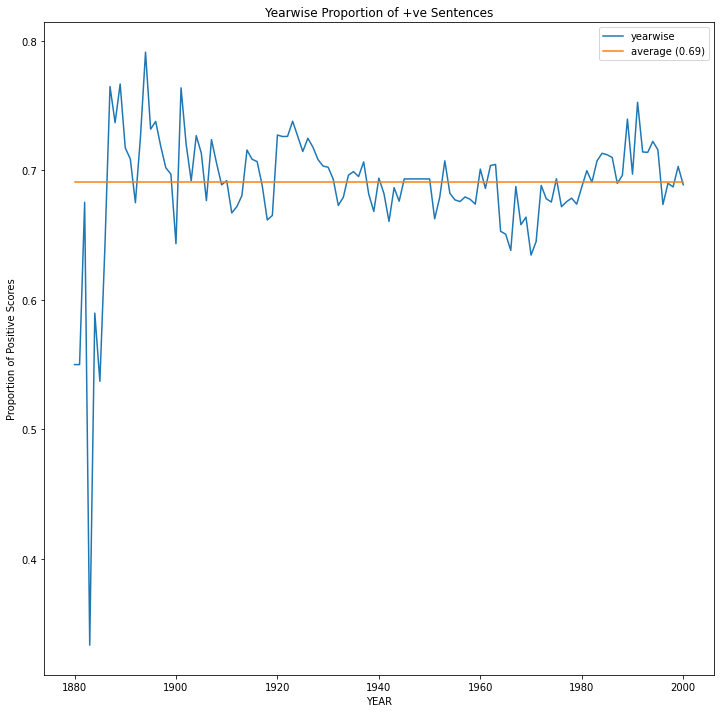

In [ ]:
# PLOTTING SENTIMENT SCORE GRAPH
# x axis
years = [year for year in sports_content]

# y axis
# polarity_yearwise
avg_score = [(sum_scores/len_scores) for year in sports_content]

plt.figure(figsize=(12,12))


plt.plot(years,polarity_yearwise,label='yearwise')
plt.plot(years,avg_score,label='average (%.2f)'%(avg_score[0]))


plt.title('Yearwise Proportion of +ve Sentences')
plt.xlabel('YEAR')
plt.ylabel('Proportion of Positive Scores')
plt.legend()
plt.show()

Based on the graph of proportion of positive sentences yearwise that has been extracted, it is clear that there isn't a lot of variance (generally hovering between the 0.65-0.78 range, the obvious outliers coming from years that I did not get a lot of data out of).

The reason for this is clear, reporting in general uses language that doesn't deviate a lot from a standard lexicon, which happens to be devoid of a lot of emotion in general. It. Is. Reporting. Those are thr ground rules, and as it happens to be, 0.7 comes out as the golden ratio for such articles. Moreover these are students writing about other students, and there's only so negative you can sound in that context.  

Having said that there is some observation that can be made, there is a general curve, however subtle, and although it is not definitive, that suggests that there is a dip towards the 1970s, and a gradual increase thereon.

Maybe this is indeed representative of the performance of Union Athletic teams, or if nothing, a general trend of sentiment in the language used to report sports events in and around Union.

If the initial hypothesis is anything to go by then we might expect some good news from the 1990s, and bad news from the 60s. I went ahead and looked up the history of Union Dutchmen Ice Hockey from wikipedia and found the following-


**Union Dutchmen Ice Hockey**:
```
Varsity era: 1919–1949
Division III era: 1975–1990
Division I era: 1991–present
```

Now this seems to suggest that there was either some truth to my theory, or this is coincidential (seeing as the low and high points I picked out differ by just a 10% when it comes to proportion of positive sentences), but I have a feeling that the general mood of reporting (as non-biased as it is), is affected by how Union's most successful sports team is performing, as a large chunk of the articles were also reporting on them.

A look at the adjectives from the aforementioned two years (the 'peak' in 1991 and the 'dip' in 1970) might reveal some more information, and hint at whether or not the initial hypothesis was anything to go by

I won't be taking the difference of either sets to compare as I feel that we will miss certain adjectives from both wordclouds that way given the nature of reporting (and how it regurgitates a lot of adjectives).

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


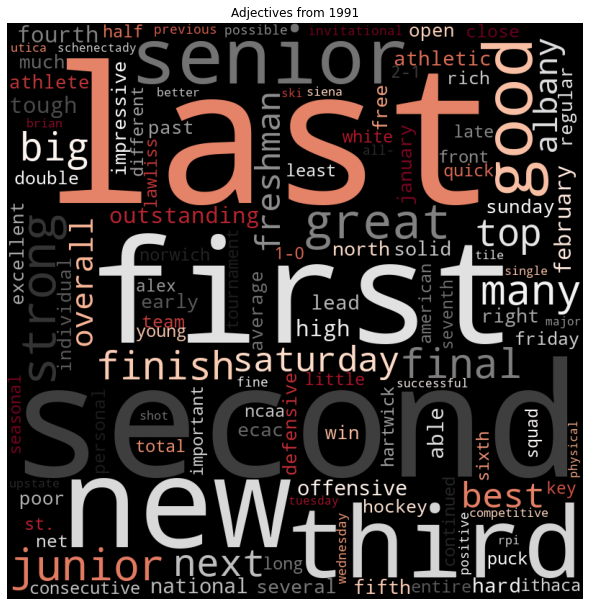

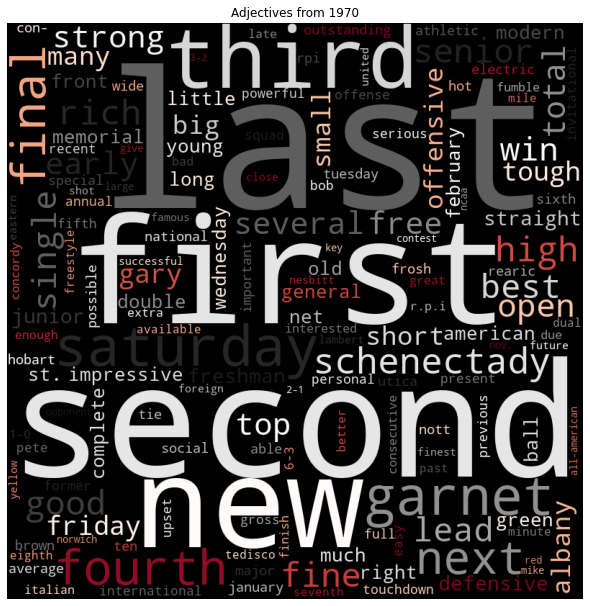

In [ ]:
# Positive Year: 1991
# Negative Year: 1970
from collections import Counter
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud
text_1970 = ' '.join(sports_content[1970])
text_1991 = ' '.join(sports_content[1991])

def word_cloud_gen(text,year):
  words = nltk.word_tokenize(text)
  clean_tokens = [word.lower() for word in words if word.lower() not in stop and word.lower() not in string.punctuation+'''’”—,''' ]
  long_clean_tokens = [word for word in clean_tokens if len(word)>2]
  tags = nltk.pos_tag(long_clean_tokens)
  adjectives = [word for word,tag in tags if tag.startswith('JJ')]
  adj_count = Counter(adjectives)
  cloud = WordCloud(width = 800, height = 800, 
                  background_color ='black',colormap="RdGy", 
                  min_font_size = 14)

  wordcloud = cloud.generate_from_frequencies(adj_count)
    
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0)
  plt.title('Adjectives from '+year) 
      
  plt.show()

word_cloud_gen(text_1991,'1991')
word_cloud_gen(text_1970,'1970')

Right off the back, vocabulary that stands out from the 1991 (supposedly positive) wordcloud, that helps my case are:

* strong
* streak
* high

(etc)

However this is not to say that there aren't any positive adjectives in the 1970 wordcloud that are missing in the former (although 1970 does feature gross, short, defensive, etc). 

And to be very frank, the *tone* in both wordclouds, seems familiar to me, nothing that would indicate triumphant times or losses. Interestingly enough a couple of winning scorelines made their way into the first word cloud (whereas there is only one in the second)!

What is more important is the fact that the word 'hockey' appears in the wordcloud when the hockey team started popping off (that is, went div1 in NCAA)

# Popular Sports

I have always been interested in sports, and there's always that debate as to what sport is the most popular, it is always interesting to see that metric play out over a long period in time. Lo and behold, we have an archive here that is perfect for that. A newspaper is always catering to the larger interests of its audience, and so naturally a sports page will report on sports that are more popular around campus, which may in turn reflect wider US culture when it comes to college level sports. Of course this is tainted by the bias of good-performing teams being more popular around campus than just the external culture, so we'll stick to trying to figure out just that. 

I got a list of the sports at Union from their website:

['Baseball', 'Basketball', 'Crew','Cross Country', 'Football', 'Ice Hockey', 'Lacrosse', 'Soccer', 'Swimming & Diving', 'Tennis', 'Track & Field', 'Golf', 'Softball', 'Volleyball', 'Field Hockey']

I will use this to generate a dictionary and track the yearwise cumulative count for each sport

In [ ]:
sports_list = ['baseball', 'basketball', 'crew', 'cross country', 'football', 'lacrosse', 'soccer', 'swimming','diving', 'tennis', 'golf', 'softball', 'volleyball', 'hockey']
sports_count_tracker = {sport:[0] for sport in sports_list}

for year in sports_content:
  year_tracker = {sport:0 for sport in sports_list}
  sports_content[year]+=['']
  text = ' '.join(sports_content[year]).lower()
  for sport in sports_list:
    count = text.count(sport)
    year_tracker[sport]+=count
  
  for sport in sports_count_tracker:
    sports_count_tracker[sport]+=[sports_count_tracker[sport][-1]+year_tracker[sport]]

print ('TOTAL COUNTS FOR EACH SPORT:')
for sport in sports_count_tracker:
  sports_count_tracker[sport].pop(0)
  print (sport,':\t',sports_count_tracker[sport][-1])

TOTAL COUNTS FOR EACH SPORT:
baseball :	 3818
basketball :	 5792
crew :	 1129
cross country :	 826
football :	 8831
lacrosse :	 3313
soccer :	 2751
swimming :	 2091
diving :	 714
tennis :	 3067
golf :	 1721
softball :	 949
volleyball :	 713
hockey :	 4628


I had to take some 'artistic license' and leeway when it came to finalising my list of sports as some sports were, well, causing problems. The longer the name of the sport was, the more prone it was to OCR errors, and the less chance of me getting a strike as compared to some other sport. The numbers I got in general were way lower than what I was expecting. As for sports that form track and field, they're not always refered to by the general classification track and field, neither is any individual event in track and field popular enough to enter the conversation here (Apologies if you were a 200m sprinter in high school Prof. Webb), so I removed track and field from the list.

Cross Country I am choosing to keep in because it got a high count as is, however I am aware that it being a longer lexicon, and two separate words, the actual count must be higher.

Ice Hockey is called just hockey more often than not, and so I clubbed the count for field and ice hockey as hockey, so we'll have to keep that in mind while analysing the data.

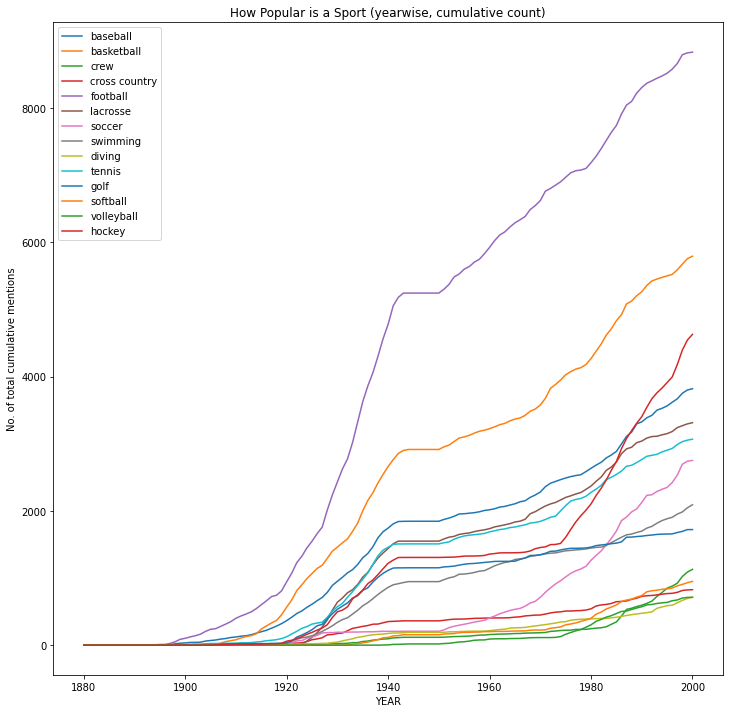

In [ ]:
# PLOTTING SENTIMENT SCORE GRAPH
years = [year for year in sports_content]
plt.figure(figsize=(12,12))

for sport in sports_count_tracker:
  # x Axis
  # years

  # y Axis
  # sports_count_tracker[sport] 
  plt.plot(years,sports_count_tracker[sport],label=sport)



plt.title('How Popular is a Sport (yearwise, cumulative count)')
plt.xlabel('YEAR')
plt.ylabel('No. of total cumulative mentions')
plt.legend()
plt.show()

I was absolutely stoked to see the result of this graph, as it captured some very important details, such as 

* The rise in popularity of the term 'hockey' coinciding with their better performances (1960s onwards), and the fit is perfect enough to justify the kink arond the 1990s as well, as those are EVEN better times for the hockey deptt at Union (going Div I).

A few conclusions: 
* Football and basketball have remained popular throghout Union's history, as have they universally pretty much
* Soccer gained in popularity around 1960 and has continued to do so since, which sounds about right
* Sports like golf plateaud, which also is understandable given the general popularity of the sport across this time period

* Interestingly enough, baseball, tennis and lacrosse haven't seen any spike in popularity neither have they been stopped being mentioned every once in a while, so I am going to go ahead and say, these are sports that Union isn't interested in at a competitive inter-collegiate level, but our rather generally popular hobby-esque uptakings in and around the campus. These sports are also those for which we have fields and equipment readily available on campus, and hence they are separate from the cluster of sports way down below.
```
In general, I think this graph gives us a very good idea of what sports are talked about most on campus, if you allow me to do so, I would love to share this with the people over at Concordy!!
```

# Women's Athletics

As one final test, I thought it would be fun to see if I could track when Union introduced women's athletic teams based on the frequency of the word 'women' on the sports pages since Union went co-ed in 1970.

In [ ]:
# Building yearwise count
yearwise_count = []
for year in sports_content:
  sports_content[year]+=''
  text = ' '.join(sports_content[year]).lower()
  yearwise_count += [text.count('women')]
print (yearwise_count)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 11, 8, 15, 9, 15, 18, 15, 7, 9, 4, 19, 3, 7, 13, 10, 32, 28, 29, 9, 28, 9, 12, 11, 9, 7, 3, 0, 0, 0, 0, 0, 0, 0, 2, 6, 5, 2, 5, 0, 2, 2, 4, 4, 6, 9, 1, 5, 7, 1, 10, 2, 2, 9, 16, 7, 2, 79, 183, 155, 119, 143, 158, 194, 278, 216, 328, 340, 389, 298, 342, 155, 331, 294, 393, 240, 280, 311, 328, 409, 675, 832, 660, 419]


No handles with labels found to put in legend.


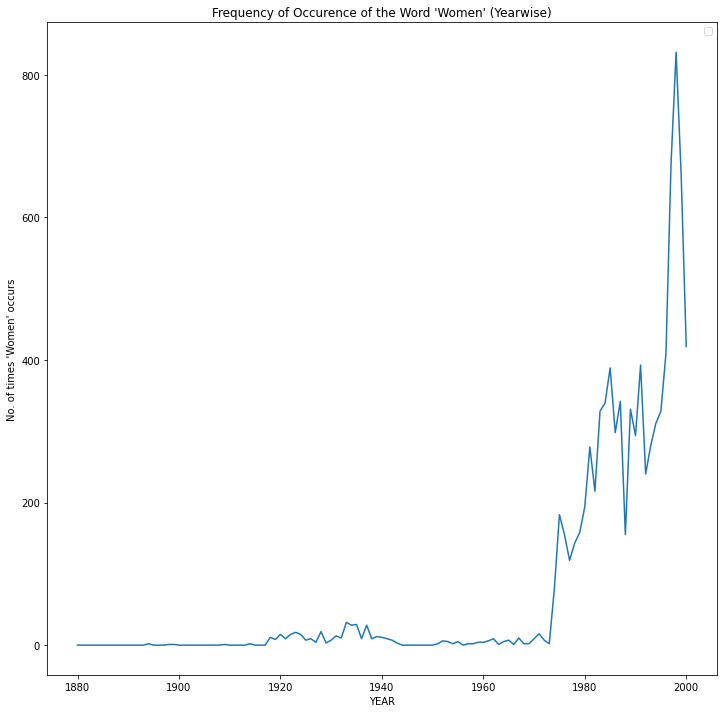

In [ ]:
# PLOTTING SENTIMENT SCORE GRAPH
years = [year for year in sports_content]
plt.figure(figsize=(12,12))

# x Axis
# years

# y Axis
# yearwise_count 
plt.plot(years,yearwise_count)



plt.title("Frequency of Occurence of the Word 'Women' (Yearwise)")
plt.xlabel('YEAR')
plt.ylabel("No. of times 'Women' occurs")
plt.legend()
plt.show()

It seems pretty clear from this graph that Union introduced Women's Athletics the same year it went co-ed, although it might be interesting to investigate what caused the term 'women' to be mentioned on the sports pages a few times during the 1920s and 1930s

Some interesting things I learnt that I wasn't looking for: 
* Americans are a lot more interested in soccer than I initially imagined
* The Ice Hockey team is called the Union Dutchmen?
* I finally know that Gridders/Gridiron are football terms
